In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [43]:

# load libraries
from FRVRS import (fu, nu, read_excel, re, nan, DataFrame, concat)


# Triage Tag Analyses Follow-on Analyses


## Generate the Data


Generate the following data for the excel sheet:
<ul>for each responder in the file, add a column for each tag correct performance and indicate for each row in those columns the performance by responder as a percentage. For example:
        <li>Responder 1: dead (1), expectant (.5), immediate (.75), delayed (.8), minimal (.9)</li></ul>

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='',
    first_responder_master_registry_scene_stats_df='',
    verbose=False
)
triage_paper_df = data_frames_dict['first_responder_master_registry_df']
print('triage_paper_df', triage_paper_df.shape[0], triage_paper_df.session_uuid.nunique(), triage_paper_df.shape[1]) # 367627 290 111
file_stats_df = data_frames_dict['first_responder_master_registry_file_stats_df']
print('file_stats_df', file_stats_df.shape[0], file_stats_df.file_name.nunique(), file_stats_df.shape[1]) # 290 290 19
scene_stats_df = data_frames_dict['first_responder_master_registry_scene_stats_df']
print('scene_stats_df', scene_stats_df.shape[0], scene_stats_df.session_uuid.nunique(), scene_stats_df.shape[1]) # 420 290 48

triage_paper_df 367627 290 111
file_stats_df 290 290 19
scene_stats_df 420 290 48


In [4]:

file_path = '../data/xlsx/swaps_walk_wave_anova_df_May30.xlsx'
swaps_walk_wave_anova_df_May30_df = read_excel(file_path)

In [12]:

# Merge only count swaps scenes
needed_columns = fu.patient_groupby_columns + [
    'patient_salt', 'action_tick', 'responder_category', 'tag_applied_type', 'patient_salt'
]
elevens_df = fu.get_elevens_data_frame(
    triage_paper_df,
    file_stats_df,
    scene_stats_df,
    needed_columns=needed_columns,
    patient_count_filter_fn=None
)

# Check if required columns are present
needed_set = set(needed_columns)
all_set = set(elevens_df.columns)
assert needed_set.issubset(all_set), f"elevens_df is missing these columns: {needed_set.difference(all_set)}"

In [14]:

# Iterate through each patient of each scene of each session of the 11-patient data frame
rows_list = []
for (session_uuid, scene_id, patient_id), patient_df in elevens_df.sort_values(['action_tick']).groupby(fu.patient_groupby_columns):
    
    # Add the groupby columns and an account of the patient's existence to the row dictionary
    row_dict = {'session_uuid': session_uuid, 'scene_id': scene_id, 'patient_id': patient_id}
    row_dict['patient_count'] = 1

    # Get the last SALT for the patient
    mask_series = ~patient_df.patient_salt.isnull()
    if mask_series.any():
        patient_salt = patient_df[mask_series].sort_values('action_tick').patient_salt.iloc[-1]
        row_dict['patient_salt'] = patient_salt

    # Get the Responder Category for the patient
    mask_series = ~patient_df.responder_category.isnull()
    if mask_series.any():
        responder_category = patient_df[mask_series].responder_category.iloc[-1]
        row_dict['responder_category'] = responder_category
    
    # Add the TAG_APPLIED tag value for this patient
    try: last_tag = fu.get_last_tag(patient_df)
    except Exception: last_tag = nan
    row_dict['last_tag'] = last_tag
    
    # Add the PATIENT_RECORD SALT value for this patient
    last_salt = fu.get_last_salt(patient_df)
    row_dict['last_salt'] = last_salt
    
    # Add the predicted tag value for this patient based on the SALT value
    try: predicted_tag = fu.salt_to_tag_dict.get(last_salt, nan)
    except Exception: predicted_tag = nan
    row_dict['predicted_tag'] = predicted_tag
    
    # Add if the tagging was correct for this patient, then the row to the list
    row_dict['is_tag_correct'] = bool(last_tag == predicted_tag)
    rows_list.append(row_dict)

# Create the tag-to-SALT data frame
is_tag_correct_df = DataFrame(rows_list)

# Convert the tagged, SALT, and predicted tag columns to their custom categorical types
is_tag_correct_df.last_tag = is_tag_correct_df.last_tag.astype(fu.colors_category_order)
is_tag_correct_df.last_salt = is_tag_correct_df.last_salt.astype(fu.salt_category_order)
is_tag_correct_df.patient_salt = is_tag_correct_df.patient_salt.astype(fu.salt_category_order)
is_tag_correct_df.predicted_tag = is_tag_correct_df.predicted_tag.astype(fu.colors_category_order)

# Sort the data frame based on the custom categorical order
is_tag_correct_df = is_tag_correct_df.sort_values('predicted_tag')

In [15]:

# Show that we have some correct taggings
mask_series = is_tag_correct_df.is_tag_correct
if mask_series.any():
    display(is_tag_correct_df[mask_series])

,session_uuid,scene_id,patient_id,patient_count,patient_salt,responder_category,last_tag,last_salt,predicted_tag,is_tag_correct
1548,75b3227f-2f3c-4fe0-b9b8-9e0fe3baa210,0,Bob_0 Root,1,DEAD,EM Resident,black,DEAD,black,True
544,25309ebf-8ca2-4678-af43-2d4030eb1c5d,0,Bob_0 Root,1,DEAD,Paramedic,black,DEAD,black,True
2884,e8be80d7-4d11-430d-93b7-bc15e1bfb445,0,Bob_0 Root,1,DEAD,Paramedic,black,DEAD,black,True
1559,77c15654-dbf5-46da-8e84-fe418cdf1c59,0,Bob_0 Root,1,DEAD,Paramedic,black,DEAD,black,True
533,251a4532-ff1f-4182-91ce-4215786a339a,0,Bob_0 Root,1,DEAD,Paramedic,black,DEAD,black,True
...,...,...,...,...,...,...,...,...,...,...
2625,d605640c-fde5-412f-8d33-b9b2744172ab,0,Gloria_8 Root,1,MINIMAL,Paramedic,green,MINIMAL,green,True
2626,d605640c-fde5-412f-8d33-b9b2744172ab,0,Helga_10 Root,1,MINIMAL,Paramedic,green,MINIMAL,green,True
2190,b05e5139-6dd4-41d2-adb5-aedfebb028a6,0,Gary_9 Root,1,MINIMAL,Medical Student,green,MINIMAL,green,True
958,44458d4a-3cce-4907-85e3-3db1375ce6bb,0,Helga_10 Root,1,MINIMAL,Paramedic,green,MINIMAL,green,True


In [16]:

# Get the percentage tag correct counts for each scene for each group
percentage_tag_correct_df = fu.get_percentage_tag_correct_data_frame(is_tag_correct_df, groupby_column='patient_salt')

# Convert the SALT columns to its custom categorical type
percentage_tag_correct_df.patient_salt = percentage_tag_correct_df.patient_salt.astype(fu.salt_category_order)

In [17]:

# Show that we have percentages higher than zero
mask_series = (percentage_tag_correct_df.percentage_tag_correct > 0.)
if mask_series.any():
    display(percentage_tag_correct_df[mask_series])

,session_uuid,scene_id,patient_salt,percentage_tag_correct
1,009b848c-ea64-4f22-bd40-711213a3d327,0,EXPECTANT,100.000000
2,009b848c-ea64-4f22-bd40-711213a3d327,0,IMMEDIATE,75.000000
3,009b848c-ea64-4f22-bd40-711213a3d327,0,DELAYED,33.333333
4,009b848c-ea64-4f22-bd40-711213a3d327,0,MINIMAL,100.000000
5,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,0,DEAD,100.000000
...,...,...,...,...
1455,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,DEAD,100.000000
1456,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,EXPECTANT,100.000000
1457,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,IMMEDIATE,100.000000
1458,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,DELAYED,50.000000


In [18]:

# Add the SALT category percentages to the ANOVA dataset
for (session_uuid, scene_id), scene_df in percentage_tag_correct_df.groupby(fu.scene_groupby_columns):
    df = scene_df.pivot_table(columns=['patient_salt'], values=['percentage_tag_correct'])
    df.columns = df.columns.map(lambda x: f'percentage_{x.lower()}_correct')
    for column_name, column_value in df.iloc[0].iteritems():
        mask_series = True
        for cn in fu.scene_groupby_columns: mask_series &= (swaps_walk_wave_anova_df_May30_df[cn] == eval(cn))
        swaps_walk_wave_anova_df_May30_df.loc[mask_series, column_name] = column_value

In [19]:

# Show what the tail end of the dataset looks like for our SALT columns
columns_list = ['ID'] + fu.scene_groupby_columns + df.columns.tolist()
swaps_walk_wave_anova_df_May30_df[columns_list].tail().T

,286,287,288,289,290
ID,Responder 287,Responder 288,NaN,NaN,NaN
session_uuid,20e5782a-d6f7-4361-a590-7e710c176765,cde3b77f-2e08-4b86-9081-d0faa979cbc8,NaN,NaN,NaN
scene_id,0,0,0,0,0
percentage_dead_correct,100.0,100.0,100.0,100.0,NaN
percentage_expectant_correct,100.0,100.0,100.0,100.0,NaN
percentage_immediate_correct,75.0,100.0,100.0,100.0,NaN
percentage_delayed_correct,100.0,0.0,100.0,100.0,NaN
percentage_minimal_correct,100.0,0.0,100.0,100.0,NaN


In [20]:

# Store the results back in a spreadsheet
swaps_walk_wave_anova_df_May30_df.to_excel(file_path, index=False)

In [21]:

# Prepare a regex pattern for double-checking of log files
'|'.join(fu.patient_salt_order)

'DEAD|EXPECTANT|IMMEDIATE|DELAYED|MINIMAL'


## Produce the Graphs


<ul>Generate the following graph
    <li>overall tag performance with violin plot (like below)</li>
    <li>separate performance graph for each group (PM, EMT, RES, MS)</li>
</ul>

In [22]:

print(
    'Create vertical violin plots of the ' + nu.conjunctify_nouns(df.columns.tolist()) + ' columns'
    ' in the swaps_walk_wave_anova_df_May30_df DataFrame all lined up next to each other in the same plot using sns.violinplot'
)

Create vertical violin plots of the percentage_dead_correct, percentage_expectant_correct, percentage_immediate_correct, percentage_delayed_correct, and percentage_minimal_correct columns in the swaps_walk_wave_anova_df_May30_df DataFrame all lined up next to each other in the same plot using sns.violinplot


In [23]:

# Select only the rows of our percentages dataset that have an equivalent in the spreadsheet
ERROR_TYPE_DF = DataFrame()
for (session_uuid, scene_id), scene_df in percentage_tag_correct_df.groupby(fu.scene_groupby_columns):
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (swaps_walk_wave_anova_df_May30_df[cn] == eval(cn))
    if mask_series.any():
        ERROR_TYPE_DF = concat([scene_df, ERROR_TYPE_DF], axis='index')

# Convert the SALT columns to its custom categorical type
ERROR_TYPE_DF.patient_salt = ERROR_TYPE_DF.patient_salt.astype(fu.salt_category_order)

In [24]:

# Show the columns available
ERROR_TYPE_DF

,session_uuid,scene_id,patient_salt,percentage_tag_correct
1455,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,DEAD,100.000000
1456,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,EXPECTANT,100.000000
1457,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,IMMEDIATE,100.000000
1458,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,DELAYED,50.000000
1459,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,MINIMAL,100.000000
...,...,...,...,...
0,009b848c-ea64-4f22-bd40-711213a3d327,0,DEAD,0.000000
1,009b848c-ea64-4f22-bd40-711213a3d327,0,EXPECTANT,100.000000
2,009b848c-ea64-4f22-bd40-711213a3d327,0,IMMEDIATE,75.000000
3,009b848c-ea64-4f22-bd40-711213a3d327,0,DELAYED,33.333333


In [27]:

# Create a violin plot function that works with our table
import matplotlib.pyplot as plt

def show_violin_plots(column_name, xlabel, title_suffix='Tags', palette=None):
    
    # Create a data frame from the data from our row-filtereed dataset
    data = {
        column_name: ERROR_TYPE_DF[column_name].tolist(),
        'percentage_tag_correct': ERROR_TYPE_DF.percentage_tag_correct.tolist()
    }
    df = DataFrame(data)
    
    # Set the style of the plot
    import seaborn as sns
    sns.set(style='whitegrid')
    
    # Create the violin plot with violins for each category of our column
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=column_name, y='percentage_tag_correct', data=df, palette=palette, inner='stick', cut=0)
    
    # Set plot labels and title
    plt.xlabel(xlabel)
    plt.ylabel('Percentage Correctly Tagged (%)')
    plt.title(f'Distribution of Patients Triaged across different {title_suffix}')
    
    # Show the plot
    plt.show()

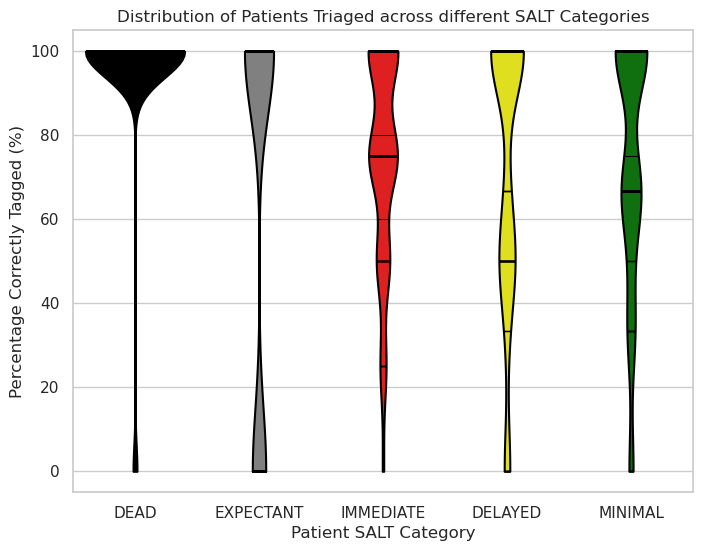

In [28]:

# Group by our made-up patient salt column
show_violin_plots('patient_salt', 'Patient SALT Category', title_suffix='SALT Categories', palette=fu.tag_colors)

In [29]:

# Get the percentage tag correct counts for each scene for each responder category
percentage_tag_correct_df = fu.get_percentage_tag_correct_data_frame(is_tag_correct_df, groupby_column='responder_category')
mask_series = ~percentage_tag_correct_df.responder_category.isnull()
percentage_tag_correct_df[mask_series]

,session_uuid,scene_id,responder_category,percentage_tag_correct
0,009b848c-ea64-4f22-bd40-711213a3d327,0,EM Resident,63.636364
1,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,0,Medical Student,81.818182
2,02f6a42e-5211-40ea-8384-824a83ab6760,0,Paramedic,63.636364
3,03b398c5-6fc8-459c-9662-ce1e0babe4b1,0,Paramedic,81.818182
4,040ba585-ccae-45ef-b4bd-a0e35ec222b0,0,Paramedic,100.000000
...,...,...,...,...
286,fdb4a6d9-72ef-4af7-bdd4-a05ba354a300,0,Paramedic,72.727273
287,fe077b96-8e52-4e1a-8ec7-e5c5f46e65c5,0,Medical Student,81.818182
288,fe2602f0-e9e8-4913-8bf3-806852ce738a,0,Medical Student,63.636364
289,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,0,Paramedic,100.000000


In [30]:

# Filter the percentage tag correct dataset so that only responders in the spreadsheet are present
ERROR_TYPE_DF = DataFrame()
for (session_uuid, scene_id), scene_df in percentage_tag_correct_df.groupby(fu.scene_groupby_columns):
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (swaps_walk_wave_anova_df_May30_df[cn] == eval(cn))
    if mask_series.any():
        ERROR_TYPE_DF = concat([scene_df, ERROR_TYPE_DF], axis='index')
ERROR_TYPE_DF

,session_uuid,scene_id,responder_category,percentage_tag_correct
290,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,Paramedic,90.909091
289,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,0,Paramedic,100.000000
288,fe2602f0-e9e8-4913-8bf3-806852ce738a,0,Medical Student,63.636364
287,fe077b96-8e52-4e1a-8ec7-e5c5f46e65c5,0,Medical Student,81.818182
286,fdb4a6d9-72ef-4af7-bdd4-a05ba354a300,0,Paramedic,72.727273
...,...,...,...,...
4,040ba585-ccae-45ef-b4bd-a0e35ec222b0,0,Paramedic,100.000000
3,03b398c5-6fc8-459c-9662-ce1e0babe4b1,0,Paramedic,81.818182
2,02f6a42e-5211-40ea-8384-824a83ab6760,0,Paramedic,63.636364
1,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,0,Medical Student,81.818182


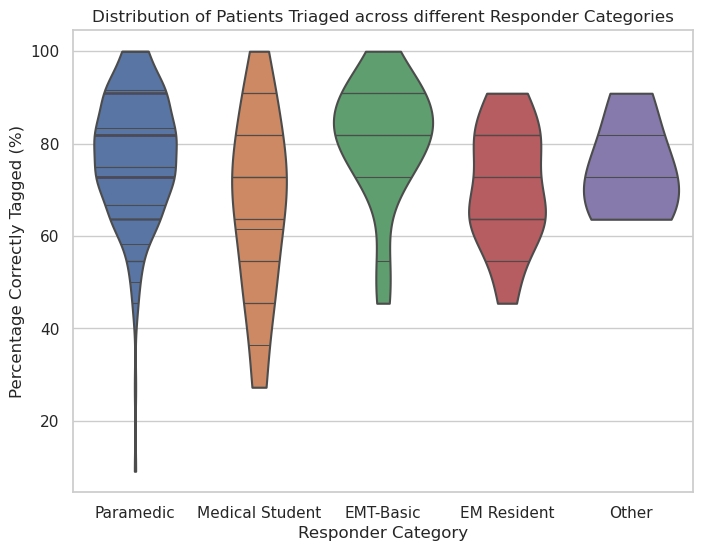

In [31]:

# So, I spot-checked Responder 288, the Paramedic, in the CSV log files, and he did indeed put
# yellow tags on all the MINIMALs (and subsequently got 0% correct). That’s the responder making
# the Paramedics look bad in the violin plot.
show_violin_plots('responder_category', 'Responder Category', title_suffix='Responder Categories')


### Reproduce the plot below but only including those that have HC_completed = 1

In [58]:

temporalize_fn = lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes')
def show_whisker_plot(
    y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=elevens_df, print_responder_counts=False, verbose=False
):
    df = get_plot_dataframe(y_column_name, scene_fn, logs_df=logs_df, verbose=verbose)
    x_column_name = 'responder_category'
    x_label = ' '.join([w.title() for w in x_column_name.split('_')])

    # Create a figure and subplots
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))

    # Create a box plot under the scatter plot; put a black square for the mean instead
    ax = sns.boxplot(
        ax=ax,
        data=df,
        fliersize=0.0,
        meanprops={'marker': 's', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 8},
        showmeans=True,
        x=x_column_name,
        y=y_column_name,
    )

    # Jitter amount
    jitter_amt = 0.1  # Adjust this value to control jitter range

    # Add jittered points
    sns.stripplot(
        alpha=0.25,  # Adjust transparency
        ax=ax,
        color='black',
        data=df,
        jitter=jitter_amt,  # Add jitter
        s=6,  # Adjust marker size
        x=x_column_name,
        y=y_column_name,
    )
    
    adjust_plot(ax, x_label, y_label, FILTERED_CATEGORIES_LIST, ytick_fn)
    plt.show()

    return fig, ax

In [37]:

FILTERED_CATEGORIES_LIST = ['Paramedic', 'EMT-Basic', 'EM Resident', 'Medical Student']
def get_plot_dataframe(
    y_column_name, scene_fn, logs_df=elevens_df, x_column_name='responder_category',
    responder_categories_list=FILTERED_CATEGORIES_LIST, verbose=False
):
    '''
    The order and labeling should be (from left to right):
        EMT-Paramedic
        EMT-Basic
        EM-Resident
        Medical Student
    '''
    rows_list = []
    for responder_category in responder_categories_list:
        if verbose: print('responder_category:', responder_category)
        mask_series = (logs_df[x_column_name] == responder_category)
        responder_categories_df = logs_df[mask_series]
        gb = responder_categories_df.groupby(fu.scene_groupby_columns)
        for (session_uuid, scene_id), scene_df in gb:
            row_dict = {}
            if 'session_uuid' in scene_df.columns: row_dict['session_uuid'] = session_uuid
            if 'scene_id' in scene_df.columns: row_dict['scene_id'] = scene_id
            row_dict[x_column_name] = responder_category
            row_dict[y_column_name] = scene_fn(scene_df)
            row_dict['scene_count'] = gb.size().shape[0]
            rows_list.append(row_dict)
    df = DataFrame(rows_list)
    
    return df

In [62]:

def adjust_plot(ax, x_label, y_label, responder_categories_list, ytick_fn=temporalize_fn):
    
    # Rotate the x-axis labels to prevent overlapping
    plt.xticks(rotation=45)

    # Label the x- and y-axis
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Humanize y tick labels
    locs, labels = plt.yticks()
    yticklabels_list = []
    for ytick_value, text_obj in zip(locs, labels):
        text_obj.set_text(ytick_fn(ytick_value))
        yticklabels_list.append(text_obj)
    plt.yticks(locs[1:], yticklabels_list[1:])

    # Re-label x tick labels
    locs, labels = plt.xticks()
    xticklabels_list = []
    for idx, text_obj in zip(locs, labels):
        text_obj.set_text(CATEGORY_DICT[responder_categories_list[idx]])
        xticklabels_list.append(text_obj)
    plt.xticks(locs, xticklabels_list)

    # Start the scale at 0 to be consistent with the other graphs
    ylim_tuple = ax.get_ylim()
    ylim_tuple = (0, ylim_tuple[1])
    ax.set_ylim(ylim_tuple)

In [60]:

# Reproduce the plot but only including those that have HC_completed = 1
import seaborn as sns
from datetime import timedelta

y_column_name = 'time_to_last_hemorrhage_controlled'
y_label = 'Hemorrhage Control for all Life-threatening Bleeding (HC_completed = 1)'
scene_fn = lambda scene_df: fu.get_time_to_last_hemorrhage_controlled(scene_df)
hc_completed_df = DataFrame([], columns=elevens_df.columns)
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (swaps_walk_wave_anova_df_May30_df[cn] == eval(cn))
    if mask_series.any():
        if fu.get_percent_hemorrhage_controlled(scene_df) == 100:
            hc_completed_df = concat([hc_completed_df, scene_df], axis='index')
mask_series = ~hc_completed_df.responder_category.isnull()
CATEGORY_DICT = {'Paramedic': 'EMT-Paramedic', 'EMT-Basic': 'EMT-Basic', 'EM Resident': 'EM-Resident', 'Medical Student': 'Medical Student'}

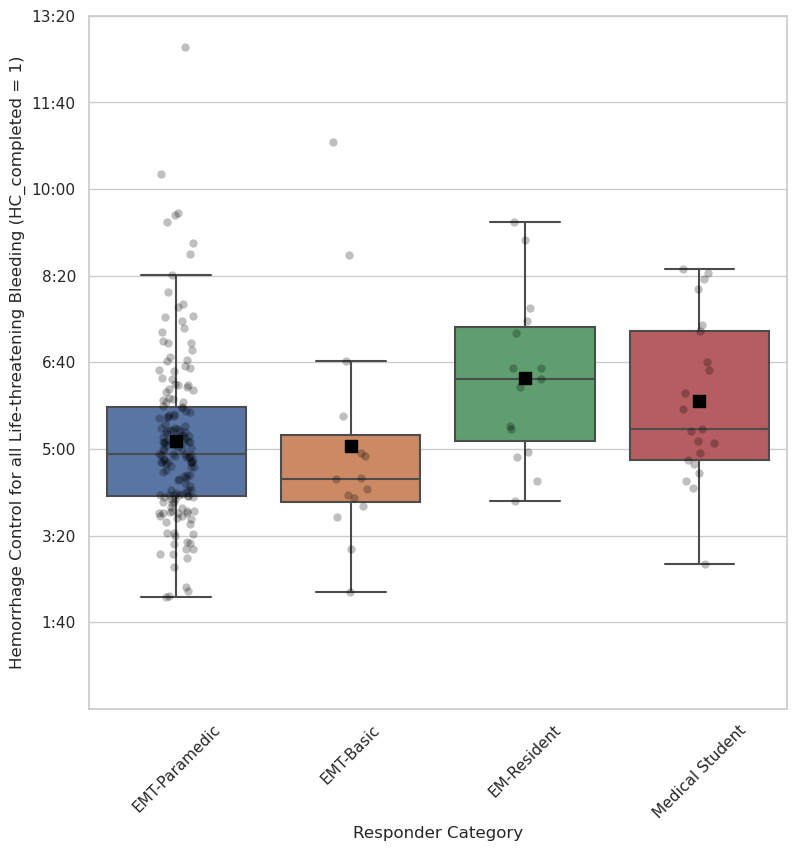

In [63]:

fig, ax = show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn, logs_df=hc_completed_df)


## Check the Definitions


1. The definition of Hemorrhage Control for all Life-threatening Bleeding is as follows: Duration of time from the scene start time until the time that the last patient who requires treatment for life-threatening bleeding has been treated with hemorrhage control procedures (when the last tourniquet or wound packing was applied)

In [3]:

# Describe the procedure via source code comments
nu.describe_procedure(fu.get_time_to_last_hemorrhage_controlled)

The procedure to calculate the time to the last hemorrhage-controlled event for patients in a scene is as follows:
    i. Get the start time of the scene (defined as the minimum action tick in the logs delimited by SESSION_ENDs)
    ii. Initialize the last controlled time to 0
    iii. Iterate through patients in the scene
    iv. Check if the patient is hemorrhaging (defined as the injury record requires the hemorrhage control procedures) and not dead
    v. Get the time to hemorrhage control for the patient (defined as the maximum action tick of the controlled hemorrhage events)
    vi. Update the last controlled time if the current controlled time is greater
    vii. Return the time to the last hemorrhage-controlled event



<i>Does this mean that this should always be the same set of patients that are hemorrhaging because all our responders for our current subset of 288 are treating the first 11 set of patients? This clarifies it. We take the time for "the last hemorrhage-controlled event", which makes sense. But this does not compute whether they completed HC for the whole scene.</i>

2. So given this definition and the fact that we have an HC time for every responder (all 282) in our current data set, does that mean that 100% of responders did do HC for all patients / injuries for the scene?

In [46]:

# Spot-check if any scenes have less than 100% hemorrhages controlled
print(
    "It would only imply that (100% of responders did do HC for all patients / injuries for the scene)"
    " if you had one injury per scene that needed to be controlled and all HC times were non-zero."
)
is_controlled_scene = True
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (swaps_walk_wave_anova_df_May30_df[cn] == eval(cn))
    if mask_series.any():
        if fu.get_percent_hemorrhage_controlled(scene_df) < 100:
            is_controlled_scene = False
            break

It would only imply that (100% of responders did do HC for all patients / injuries for the scene) if you had one injury per scene that needed to be controlled and all HC times were non-zero.


In [47]:

if is_controlled_scene:
    print(
        "In your data, there is not a scene which did not have all of their hemorrhages controlled"
    )

# Verify the percentage for the above scene
else:
    percentage = fu.get_percent_hemorrhage_controlled(scene_df)
    print(
        f"In your data, there is a scene which had only {percentage} of their hemorrhages controlled"
    )

In your data, there is a scene which had only 80.0 of their hemorrhages controlled


In [48]:

# Find a hemorrhaging non-dead patient who didn't get controlled
is_controlled_patient = True
scene_start = fu.get_scene_start(scene_df)
for patient_id, patient_df in scene_df.sort_values(['action_tick']).groupby('patient_id'):
    time_to_hemorrhage_control = fu.get_time_to_hemorrhage_control(patient_df, scene_start)
    if fu.get_is_patient_hemorrhaging(patient_df) and (not fu.get_is_patient_dead(patient_df)) and (not time_to_hemorrhage_control):
        is_controlled_patient = False
        break
if is_controlled_patient:
    print(
        "In the scene above, there is not a patient who is hemorrhaging and who is not dead"
        " who did not have at least one of their hemorrhages controlled"
    )
else:
    print(
        f"In the scene above, there is a patient called '{patient_id}' who is hemorrhaging and who is not dead"
        " who did not have at least one of their hemorrhages controlled"
    )

In the scene above, there is not a patient who is hemorrhaging and who is not dead who did not have at least one of their hemorrhages controlled



<i>And if they have at least one hemorrhage, we compute a time.</i>

3. If no to point 2, is it possible that we computed a time for a responder when he did not in fact treat all injuries on all patients who required life-threatening treatment for the scene? So is it possible that for example they treated injuries on three patients, but left one of the life-threatening bleeding injuries untreated and this still produced an HC time?

In [75]:

# Loop through each injury, examining its required procedures and wrong treatments
rows_list = []
for (session_uuid, scene_id), scene_df in triage_paper_df.groupby(fu.scene_groupby_columns):
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (swaps_walk_wave_anova_df_May30_df[cn] == eval(cn))
    if mask_series.any():
        for patient_id, patient_df in scene_df.groupby('patient_id'):
            is_patient_dead = fu.get_is_patient_dead(patient_df)
            if not is_patient_dead:
                responder_name = swaps_walk_wave_anova_df_May30_df[mask_series].ID.squeeze()
                row_dict = {'responder_name': responder_name, 'patient_id': patient_id}
                for injury_id, injury_df in patient_df.groupby('injury_id'):
                    
                    # Check if an injury record or treatment exists for a hemorrhage-related procedure
                    is_injury_hemorrhage = fu.get_is_injury_hemorrhage(injury_df)
                    if is_injury_hemorrhage:
                        
                        # Check if the injury was treated correctly
                        is_correctly_treated = fu.get_is_injury_correctly_treated(injury_df, patient_df)
                        
                        # See if there are any tools applied that are associated with the hemorrhage injuries
                        is_tool_applied_correctly = fu.get_is_hemorrhage_tool_applied(injury_df, patient_df)
                        
                        # Count any hemorrhage-related injuries that have been treated, and not wrong, and not counted twice
                        if is_correctly_treated or is_tool_applied_correctly:
                            row_dict['treated_injury'] = injury_id
                        else:
                            row_dict['untreated_injury'] = injury_id
                
                rows_list.append(row_dict)
df = DataFrame(rows_list).drop_duplicates()

In [76]:

mask_series = ~df.treated_injury.isnull() & ~df.untreated_injury.isnull()
if mask_series.any():
    print("It is possible. For instance:")
    groupby_columns = ['patient_id', 'treated_injury', 'untreated_injury']
    for (patient_id, treated_injury, untreated_injury), untreated_injury_df in df[mask_series].groupby(groupby_columns):
        mask_series = ~untreated_injury_df.responder_name.isnull()
        responder_names_str = nu.conjunctify_nouns(sorted(untreated_injury_df[mask_series].responder_name.unique()))
        print(
            f"{patient_id} had a {untreated_injury} which {responder_names_str} did not treat, but treated"
            f" the {treated_injury} which gave the time to the last hemorrhage-controlled event for that patient."
        )

It is possible. For instance:
Mike_5 Root had a R Thigh Laceration which Responder 77 did not treat, but treated the R Side Puncture which gave the time to the last hemorrhage-controlled event for that patient.
Mike_5 Root had a R Side Puncture which Responder 115, Responder 117, Responder 125, Responder 139, Responder 149, Responder 169, Responder 190, Responder 200, Responder 203, Responder 210, Responder 233, Responder 235, Responder 240, Responder 252, Responder 269, Responder 282, and Responder 68 did not treat, but treated the R Thigh Laceration which gave the time to the last hemorrhage-controlled event for that patient.



4. If yes to point 3, we asked a few weeks ago for the following: For the attached dataset, can you add a column "HC_completed" where you provide a 1 for hemorrage control completed for that responder for the scene and a 0 for those that didn't? You replied by computing "a percentage of hemorrhage-related injuries that have been controlled of 100% to be equal to one and anything less than that to equal 0". The result was the datasheet that showed that 78% of responders completed HC.

In [77]:

# Describe the procedure via source code comments
nu.describe_procedure(fu.get_percent_hemorrhage_controlled, docstring_prefix='The HC_completed procedure to')

The procedure to calculate the percentage of hemorrhage-related injuries that have been controlled in a scene is as follows:
    i. Loop through each injury, examining its required procedures and wrong treatments
    ii. Check if an injury record or treatment exists for a hemorrhage-related procedure
    iii. Count any injuries requiring hemorrhage control procedures
    iv. Check if the injury was treated correctly
    v. See if there are any tools applied that are associated with the hemorrhage injuries
    vi. Count any hemorrhage-related injuries that have been treated, and not wrong, and not counted twice
    vii. Calculate the percentage of controlled hemorrhage-related injuries
    viii. Return the percentage of hemorrhage cases controlled



<i>We really do need to compute this separately to get the full picture of HC for the entire scene.</i>

5.	If the calculation in point 4 is correct, what does the HC time mean for a responder who did not complete HC and a time for a responder that did complete HC? For example:
    <ul><li>Responder 1 did not complete HC (column R). HC is 387864 ms. What does the time indicate?</li></ul>

In [84]:

def show_time_indication(responder_number, hc_milliseconds):
    
    # Get Responder's data
    session_uuid = swaps_walk_wave_anova_df_May30_df.loc[responder_number-1].session_uuid
    scene_id = swaps_walk_wave_anova_df_May30_df.loc[responder_number-1].scene_id
    mask_series = (elevens_df.session_uuid == session_uuid) & (elevens_df.scene_id == scene_id)
    scene_df = elevens_df[mask_series]
    
    # Loop through each injury, examining its required procedures and wrong treatments
    scene_start = fu.get_scene_start(scene_df)
    for patient_id, patient_df in scene_df.groupby('patient_id'):
        is_patient_dead = fu.get_is_patient_dead(patient_df)
        if not is_patient_dead:
            time_to_hemorrhage_control = fu.get_time_to_hemorrhage_control(patient_df, scene_start)
            if time_to_hemorrhage_control == hc_milliseconds:
                print(f"The time indicates when {patient_id} got their ", end='')
            for injury_id, injury_df in patient_df.groupby('injury_id'):
                
                # Check if an injury record or treatment exists for a hemorrhage-related procedure
                is_injury_hemorrhage = fu.get_is_injury_hemorrhage(injury_df)
                if is_injury_hemorrhage:
                    
                    # Check if the injury was treated correctly
                    is_correctly_treated = fu.get_is_injury_correctly_treated(injury_df, patient_df)
                    
                    # See if there are any tools applied that are associated with the hemorrhage injuries
                    is_tool_applied_correctly = fu.get_is_hemorrhage_tool_applied(injury_df, patient_df)
                    
                    # Count any hemorrhage-related injuries that have been treated, and not wrong, and not counted twice
                    if is_correctly_treated or is_tool_applied_correctly:
                        if time_to_hemorrhage_control == hc_milliseconds:
                            print(f"{injury_id} controlled minus the start time.")

In [85]:

show_time_indication(1, 387864)

The time indicates when Lily_4 Root got their L Side Puncture controlled minus the start time.



<ul><li>Responder 4 did complete HC. HC is 342335. What does the time indicate?</li></ul>

In [86]:

show_time_indication(4, 342335)

The time indicates when Mike_5 Root got their R Side Puncture controlled minus the start time.



<i>And in this case, Mike_5 was the last HC event</i>